In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from resnet18_32x32 import ResNet18_32x32
from torch.utils.data import TensorDataset, DataLoader



device = torch.device("cuda" if torch.cuda.is_available() else False)

# 加载训练好的模型
model = ResNet18_32x32().to(device)
model.load_state_dict(torch.load('./resnet/best.ckpt'))
output = "./output"


# 加载CIFAR-10数据集
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

# 加载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4)


# 定义CIFAR-10类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 对测试集进行预测
model.eval()
label_list = []
probs_list = []


with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1) 
        label_list.append(predicted) #训练数据集
        probs_list.append(probabilities) #训练数据集
#        print("Size of tensor_list:", len(predicted))
#for i in range(100):
#    predicted, probabilities = tensor_list[i]
#    print(f"Element {i+1}:")
#    print("Predicted Label:", predicted)
#    print("Probabilities:", probabilities)
#    print()


Files already downloaded and verified
Files already downloaded and verified


In [4]:
#参数加载
latent_dim = 100
lr = 0.0002
batch_size = 32
num_epochs = 100
num_classes = 10

class Generator(nn.Module):
    

    
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, latent_dim)
        self.generator = nn.Sequential(
            nn.Linear(latent_dim * 2 , 128),  # 将噪音维度加入生成器输入维度
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
            
        )

    def forward(self, labels, noise):
        gen_input = self.label_embed(labels)
        gen_input_with_noise = torch.cat((gen_input, noise), -1)  # 将噪音和标签嵌入向量连接起来
        class_probs = self.generator(gen_input_with_noise)
        return class_probs



class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.discriminator = nn.Sequential(
            nn.Linear(num_classes * 2 , 512),  # 输入维度为类别数乘以2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        

    def forward(self, class_probs, labels):
        label_embed = self.label_embed(labels)
        input_tensor = torch.cat((class_probs, label_embed), dim=1)
        validity = self.discriminator(input_tensor)
        return validity

In [5]:
# 创建生成器和判别器实例
generator = Generator(latent_dim, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)

generator.load_state_dict(torch.load('./output/best/32/generator200+100.pth'))

discriminator.load_state_dict(torch.load('./output/best/32/discriminator200+100.pth'))


# 定义损失函数和优化器
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

In [6]:
d_losses = []  # 存储判别器损失值
g_losses = []  # 存储生成器损失值
# 训练生成对抗网络

# 将label_list和probs_list转换为Tensor对象
# 将label_list和probs_list转换为整数类型的Tensor对象
# 将label_list和probs_list转换为Tensor对象
label_tensor = torch.cat(label_list, dim=0)
probs_tensor = torch.cat(probs_list, dim=0)

dataset = TensorDataset(label_tensor, probs_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


for epoch in range(num_epochs):
    for i, (predicted, probabilities) in enumerate(dataloader):
        # 将数据移动到GPU
        predicted = predicted.to(device)
        probabilities = probabilities.to(device)

        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_class_probs = generator(gen_labels, noise)
        
        
        # 训练判别器
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        optimizer_D.zero_grad()
        # 判别器判断真实类别概率分布
        real_validity = discriminator(probabilities, predicted)
        real_loss = adversarial_loss(real_validity, real_labels)

        # 判别器判断生成的类别概率分布
        fake_validity = discriminator(gen_class_probs.detach(), gen_labels)
        fake_loss = adversarial_loss(fake_validity, fake_labels)

        d_loss = (real_loss + fake_loss) /2 
        d_loss.backward()
        optimizer_D.step()
        
        
        # 训练生成器
        optimizer_G.zero_grad()

        # 生成器生成类别概率分布，并判别器判断生成的类别概率分布
        gen_validity = discriminator(gen_class_probs, gen_labels)
        g_loss = adversarial_loss(gen_validity, real_labels)

        g_loss.backward()
        optimizer_G.step()
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f"[Epoch {epoch + 1}/{num_epochs}] Label: {gen_labels}")
    print(f"[Epoch {epoch + 1}/{num_epochs}] Generated Probs: {gen_class_probs.detach().cpu().numpy()}")
    print(f"[Epoch {epoch + 1}/{num_epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    if (epoch + 1) % 20 == 0:
        # 保存生成器和判别器的状态字典
        torch.save(generator.state_dict(), f'./output/best/32/generator300+{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'./output/best/32/discriminator300+{epoch + 1}.pth')

[Epoch 1/100] Label: tensor([0, 7, 7, 0, 6, 9, 1, 0, 5, 4, 6, 7, 6, 4, 0, 2, 3, 7, 6, 5, 4, 8, 9, 2,
        0, 4, 8, 0, 7, 3, 2, 5], device='cuda:0')
[Epoch 1/100] Generated Probs: [[9.95541275e-01 1.57596456e-04 5.95656729e-06 8.46026705e-06
  1.53498002e-06 2.98677442e-05 5.25042978e-08 4.11346671e-04
  3.60628730e-03 2.37557208e-04]
 [2.86314003e-06 1.02543298e-08 3.15422774e-04 7.25951977e-05
  9.04256922e-06 8.10713318e-05 2.33341507e-06 9.99461472e-01
  5.51998128e-05 5.55109558e-09]
 [4.46318666e-07 2.12744533e-09 1.42279547e-04 5.59189575e-05
  9.81896483e-06 8.13510560e-05 1.36351628e-06 9.99696612e-01
  1.22254824e-05 9.52854462e-10]
 [9.93987918e-01 9.70213223e-05 2.76757828e-06 1.57629529e-05
  1.15261719e-06 3.19409482e-05 2.61355417e-08 3.31964024e-04
  5.33297332e-03 1.98347509e-04]
 [2.83917075e-07 7.48040111e-06 1.14217501e-05 3.96409724e-03
  1.16779556e-05 1.12230946e-05 9.95993495e-01 5.79611825e-09
  1.77048065e-08 3.04268752e-07]
 [5.43572532e-05 1.27970509e-03 5

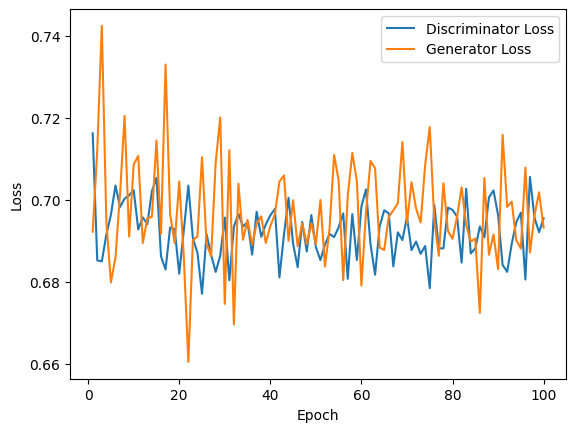

In [7]:
# 可视化损失值
plt.plot(range(1, num_epochs + 1), d_losses, label='Discriminator Loss')

plt.plot(range(1, num_epochs + 1), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()